# **Lezione 4**

### **Introduzione**
In Meccanica Statistica, la distribuzione di Maxwell-Boltzmann è una distribuzione di probabilità utilizzata per descrivere le velocità delle particelle nei gas idealizzati.   
I gas rarefatti a temperature ordinarie si comportano in modo molto simile a un gas ideale e la distribuzione delle velocità di Maxwell-Boltzmann rappresenta una buona approssimazione per tali gas. Per un sistema tridimensionale, la sua formula è:
$$
p(v,T) = \left( \frac{m}{2\pi k_B T} \right)^{3/2} 4\pi v^2 e^{-\frac{m v^2}{2 k_B T}}
$$

Utilizzando le unità ridotte di LJ (Lunghezza: $\sigma$; Energia: $\epsilon$; Massa: la massa, $m$, delle particelle; Temperatura: $\epsilon/k_B$; Velocità: $\sqrt{\epsilon/m}$) la sua forma diventa:
$$
p(v^*,T^*) = \frac{1}{(2\pi T^*)^{3/2}} 4\pi (v^*)^2 e^{-\frac{(v^*)^2}{2 T^*}}
$$

###  **Esercizio 4.1**

La richiesta dell'esercizio è quella di implementare all'interno del codice NSL_SIMULATOR il calcolo della distribuzione di Maxwell-Boltzmann, $p(v^*,T^*)$, utilizzando il data blocking per ottenere le  medie di singoli blocchi, i valori medi progressivi e le incertezze progressive per $p(v^*,T^*)$. 

Vediamo dunque come ho realizzato le richieste nel codice: 

1. Costruzione dell'istogramma normalizzato della distribuzione delle velocità delle particelle
    ```cpp
    if(_measure_pofv){
        double norm = 1.0/(double(_npart)*_bin_size_v);
        for(int i=0; i<_npart; i++){
            double speed =sqrt(dot(_particle(i).getvelocity(),_particle(i).getvelocity()));
            int bin = int(speed/_bin_size_v);
            if(bin < _n_bins_v){
            _measurement(_index_pofv + bin) += 1*norm;
            }
        }
    }
    ```
    dove :
    * `norm=1/(_npart * _bin_size_v)` è il fattore di normalizzazione, che assicura che l'area sotto la distribuzione sia, appunto, normalizzata a 1.
    * per ogni particella si calcola la velocità scalare $v=\sqrt{v_x^2+ v_y^2 + v_z^2}$
    * si individua il bin corrispondente `int bin = int(speed/_bin_size_v)`
    * se il bin è valido, si aggiorna il conteggio in `_measurement( )`


2. Esecuzione del data blocking e salvataggio su file dell'istogramma ottenuto

    ```cpp
    if(_measure_pofv){
        coutf.open("../OUTPUT/pofv.dat", ios::app);
        for (int i = 0; i < _n_bins_v; ++i) {
            double velocity_bin = (i + 0.5) * _bin_size_v;
            double prob_density = _average(_index_pofv + i);
            sum_average = _global_av(_index_pofv + i);
            sum_ave2 = _global_av2(_index_pofv + i);
            coutf << setw(12) << velocity_bin
                  << setw(12) << prob_density
                  << setw(12) << sum_average / double(blk)
                  << setw(12) << this->error(sum_average, sum_ave2, blk) 
                  << endl;
        }
        coutf << endl << endl;
        coutf.close();
    }
    ```
    dove sul file stampo:
    + la posizione del centro del bin di velocità `(i + 0.5) * _bin_size_v` 
    + la media del valore di $p(v^∗)$ per il bin salvata in `_average( )`
    + Il valor medio progressivo `sum_average / double(blk)`
    + l'incertezza statistica `this->error( )`

Una volta implementati i metodi per il calcolo della distribuzione di velocità, vediamo come questi si applicano allo studio della convergenza verso l'equilibrio di un sistema.

### **Esercizio 4.2**
In questo esercizio si studia l’evoluzione temporale di un gas rarefatto modellato con il potenziale di Lennard-Jones, inizialmente preparato in una configurazione altamente ordinata a bassa entropia:
+ Le posizioni delle particelle sono disposte secondo una struttura cristallina fcc (occupando in ciascuna dimensione metà del volume della box di simulazione)

+ Le velocità iniziali sono assegnate in modo deterministico, secondo una distribuzione delta di Dirac: ogni particella ha una sola componente di velocità pari a $\pm v_{T^∗}$, compatibile con l’energia cinetica corrispondente alla temperatura iniziale $T^∗$. Nel codice ho implementato l'assegnazione in questo modo:
```cpp
        double v_star = sqrt(3.0 * _temp);  
        for(int i=0; i<_npart; i+=6){
            vx(i)   =   v_star;
            vy(i+1) =   v_star;
            vz(i+2) =   v_star;
            vx(i+3) = - v_star;
            vy(i+4) = - v_star;
            vz(i+5) = - v_star;
        }
```

L’obiettivo è mostrare come il sistema evolva spontaneamente verso una situazione di equilibrio, in cui la distribuzione delle velocità passa dalla delta alla distribuzione di Maxwell–Boltzmann. Durante questa evoluzione si osserva anche un aumento dell'entropia del sistema, associato a una configurazione spaziale e cinetica via via più disordinata.

Di seguito riporto proprio due grafici che raffigurano l'evoluzione del sistema verso l'equilibrio.

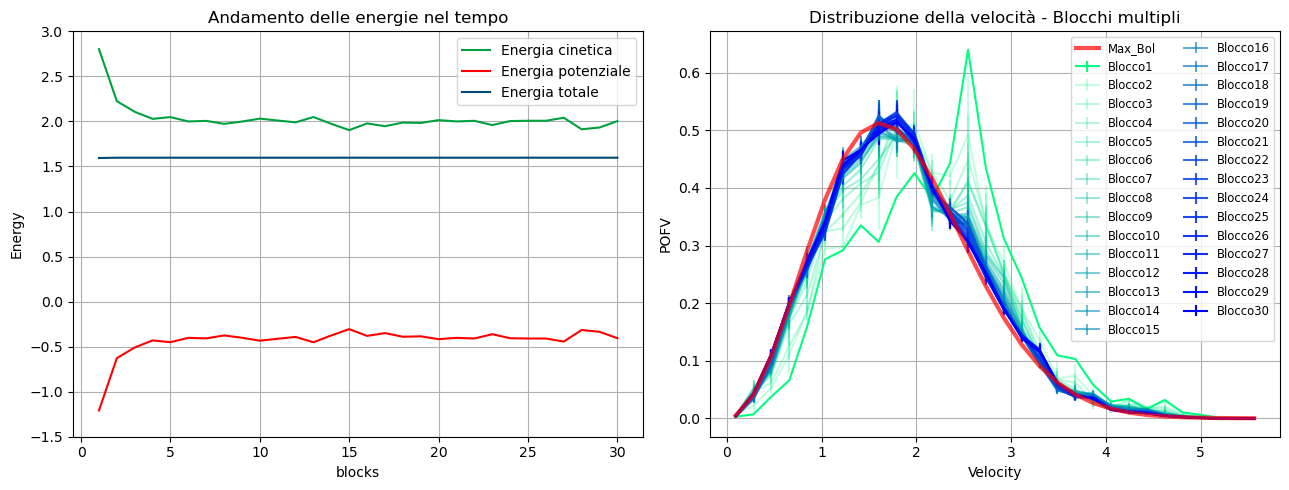

In [2]:
import matplotlib.pyplot as plt
import numpy as np

figure, axs = plt.subplots(1, 2, figsize=(13,5))

blocks, ken = np.loadtxt("4.2_NSL_SIMULATOR/OUTPUT/kinetic_energy.dat", usecols=(0,1), unpack='True')
pen = np.loadtxt("4.2_NSL_SIMULATOR/OUTPUT/potential_energy.dat", usecols=(1), unpack='True')
ten = np.loadtxt("4.2_NSL_SIMULATOR/OUTPUT/total_energy.dat", usecols=(1), unpack='True')

axs[0].plot(blocks, ken, color="#00A13E", label="Energia cinetica")
axs[0].plot(blocks, pen, color="#FF0000", label="Energia potenziale")
axs[0].plot(blocks, ten, color="#004872", label="Energia totale")
axs[0].set_ylim(-1.5, 3.0)
axs[0].set_xlabel('blocks')
axs[0].set_ylabel('Energy')
axs[0].set_title('Andamento delle energie nel tempo')
axs[0].legend()
axs[0].grid(True)

# =========================================================================================

def maxwell_boltzmann(x):
    return 1/(2*np.pi*1.31)**(3.0/2.0) * 4 * np.pi * x**2 * np.exp(-x**2 / (2 * 1.31))

# Parametri
n_bins = 30
n_blocks = 30
path = "4.2_NSL_SIMULATOR/OUTPUT/pofv.dat"

# 0 = bin di velocità, 2 = media POFV, 3 = errore
raw_vel, raw_counts, raw_err = np.loadtxt(path, usecols=(0, 2, 3), unpack=True)
 
# Mappa di colori
colors = plt.cm.winter(np.linspace(0, 1, n_blocks))
colors = colors[::-1]

for j in range(0, n_blocks):
    start = j * n_bins
    end = start + n_bins
    vel = raw_vel[start:end]
    counts = raw_counts[start:end]
    err = raw_err[start:end]
    alpha = j+1

    alpha = 0.2 + 0.8 * j / (n_blocks - 1)
    if j == 0:
        alpha = 1.0

    axs[1].errorbar(vel, counts, yerr=err, label='Blocco'+str(j+1), color=colors[j], alpha=alpha)
    if j==n_blocks-1: axs[1].plot(vel, maxwell_boltzmann(vel), color="#FF0000", label='Max_Bol', zorder=10, linewidth=3, alpha=0.7)

# Etichette e legenda
axs[1].set_xlabel("Velocity")
axs[1].set_ylabel("POFV")
axs[1].set_title("Distribuzione della velocità - Blocchi multipli")
axs[1].legend(fontsize="small", ncol=2, loc="upper right")
axs[1].grid(True)
plt.tight_layout()
plt.show()

<div style="width: 48%; float: left;">

A sinistra, il grafico mostra l'andamento delle tre componenti energetiche del sistema nel tempo:

+ L'energia cinetica (in verde) parte da un valore molto elevato, coerente con la distribuzione iniziale delle velocità. Nel tempo, decresce e si assesta su un valore più basso, corrispondente all’equilibrio termico raggiunto dal sistema.

+ L'energia potenziale (in rosso) parte molto bassa, a causa della disposizione iniziale ordinata (cristallo fcc) con molte interazioni ravvicinate. Durante l’evoluzione, tende a salire, indicando che mediamente le particelle si allontanano.

+ L'energia totale (in blu) resta costante, confermando la conservazione dell’energia totale in un ensemble microcanonico (NVE).

</div>

<div style="width: 48%; float: right;">

A destra il grafico mostra l’evoluzione della distribuzione di probabilità della velocità $p(v^∗)$ nei vari blocchi, confrontata con la distribuzione teorica di Maxwell–Boltzmann (curva rossa):

+ Nei primi blocchi (colori più chiari), la distribuzione è fortemente distante dalla maxwelliana. È ancora presente un picco stretto in corrispondenza della velocità iniziale imposta.

+ Col passare del tempo, la distribuzione si allarga progressivamente e tende ad assumere una forma tipicamente maxwelliana.

+ A partire dal blocco 20 circa, le curve dei successivi si sovrappongono alla curva teorica, mostrando la convergenza, anche se rimangono visibili gli effetti degli istanti iniziali che sono contati nelle medie progressive. 

</div>

<div style="clear: both;"></div>

Dunque pur partendo da una condizione lontana dall’equilibrio, il sistema evolve spontaneamente verso uno stato caratterizzato da una distribuzione delle velocità compatibile con l’equilibrio termico.

### **Esercizio 4.3**
Lo scopo di questo esercizio è indagare cosa accade quando si inverte la direzione del tempo in una simulazione di dinamica molecolare. In particolare, vogliamo verificare se il sistema è in grado di "tornare indietro" verso la condizione iniziale a bassa entropia, da cui era partito nell’esercizio 4.2.

Per eseguire correttamente la simulazione temporale inversa ho apportato le seguenti modifiche:

+ Ho scambiato rispettivamente la configurazione finale e quella dell'ultimo passo, in modo che il sistema evolva naturalmente in senso antiorario senza bisogno di alcuna modifica

+ Ho verificato che la temperatura iniziale del sistema (quella calcolata dalla configurazione finale) fosse coerente, evitando così squilibri energetici dovuti a un'errata condizione iniziale.

A questo punto, ho avviato la simulazione in senso inverso con gli stessi parametri temporali della simulazione diretta.
Di seguito sono riportati i grafici relativi all'evoluzione delle energie e della distribuzione delle velocità:

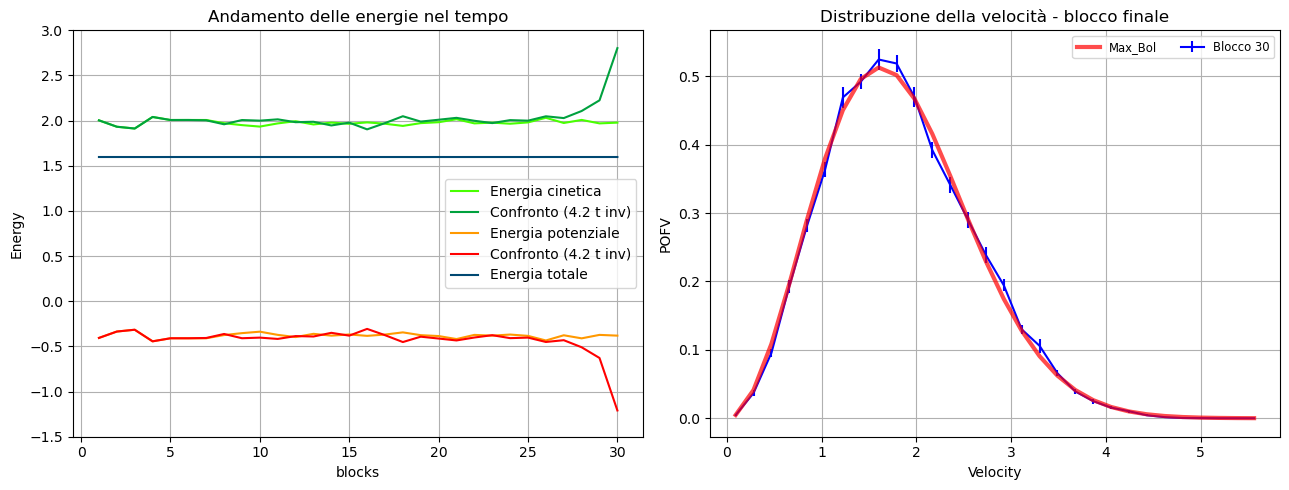

In [11]:
import matplotlib.pyplot as plt
import numpy as np

figure, axs = plt.subplots(1, 2, figsize=(13,5))

blocks, ken = np.loadtxt("4.3_NSL_SIMULATOR/OUTPUT/kinetic_energy.dat", usecols=(0,1), unpack='True')
pen = np.loadtxt("4.3_NSL_SIMULATOR/OUTPUT/potential_energy.dat", usecols=(1), unpack='True')
ten = np.loadtxt("4.3_NSL_SIMULATOR/OUTPUT/total_energy.dat", usecols=(1), unpack='True')

ken_inv = np.loadtxt("4.2_NSL_SIMULATOR/OUTPUT/kinetic_energy.dat", usecols=(1), unpack='True')
ken_inv = ken_inv[::-1]
pen_inv = np.loadtxt("4.2_NSL_SIMULATOR/OUTPUT/potential_energy.dat", usecols=(1), unpack='True')
pen_inv = pen_inv[::-1]

axs[0].plot(blocks, ken, color="#49FF01FF", label="Energia cinetica")
axs[0].plot(blocks, ken_inv, color="#00A13E", label="Confronto (4.2 t inv)")
axs[0].plot(blocks, pen, color="#FF9900", label="Energia potenziale")
axs[0].plot(blocks, pen_inv, color="#FF0000", label="Confronto (4.2 t inv)")
axs[0].plot(blocks, ten, color="#004872", label="Energia totale")
axs[0].set_ylim(-1.5, 3.0)
axs[0].set_xlabel('blocks')
axs[0].set_ylabel('Energy')
axs[0].set_title('Andamento delle energie nel tempo')
axs[0].legend()
axs[0].grid(True)

# =========================================================================================

def maxwell_boltzmann(x):
    return 1/(2*np.pi*1.31)**(3.0/2.0) * 4 * np.pi * x**2 * np.exp(-x**2 / (2 * 1.31))

# Parametri
n_bins = 30
n_blocks = 30
path = "4.3_NSL_SIMULATOR/OUTPUT/pofv.dat"

# 0 = bin di velocità, 2 = media POFV, 3 = errore
raw_vel, raw_counts, raw_err = np.loadtxt(path, usecols=(0, 2, 3), unpack=True)
 
# Mappa di colori
colors = plt.cm.winter(np.linspace(0, 1, n_blocks))
colors = colors[::-1]

start = n_bins*(n_blocks-1)
end = start + n_bins 
vel = raw_vel[start:end]
counts = raw_counts[start:end]
err = raw_err[start:end]

axs[1].errorbar(vel, counts, yerr=err, label='Blocco 30', color=colors[29])
axs[1].plot(vel, maxwell_boltzmann(vel), color="#FF0000", label='Max_Bol', zorder=10, linewidth=3, alpha=0.7)
axs[1].set_xlabel("Velocity")
axs[1].set_ylabel("POFV")
axs[1].set_title("Distribuzione della velocità - blocco finale")
axs[1].legend(fontsize="small", ncol=2, loc="upper right")
axs[1].grid(True)

plt.tight_layout()
plt.show()

Nel grafico di sinistra sono rappresentati i valori medi per le seguenti grandezze: l'energia cinetica in verde chiaro, l'energia potenziale in arancio e infine l'energia totale in blu, confrontati con l'evoluzione al "contrario" delle energie durante la fase di equilibrizzazione (colori come sopra).

Anche se in teoria, nella dinamica è possibile invertire il tempo e il Verlet è t-simmetrico, i grafici mostrano che il sistema non ritorna allo stato iniziale: le due traiettorie si mantengono vicine solo per un breve intervallo, poi divergono rapidamente.   
Questa divergenza è attribuibile al fatto che, in dinamica molecolare, si campiona lo spazio delle fasi in base alla probabilità che le diverse configuarazioni hanno di verificarsi. Dato che la configuarazione di partenza dell'esercizio precedente è molto improbabile, l'unica possibilità di raggiungerla è quella di fare a ritroso esattamente gli stessi passi nello spazio delle fasi, anche una piccola deviazione e la configurazione finale sarà diversa.   
Quello che si vede qui è proprio questo: a causa degli errori numerici che occorrono durante l'evoluzione temporale, lo spazio delle fasi non viene campionato in modo speculare a prima e quindi il sistema evolve in modo diverso, non raggiungendo la configurazione iniziale.

Alla fine si raggiunge un'altra configurazione di equilibrio, come dimostrato dalla distribuzione di velocità, riportata nel grafico a destra, che ricalca entro le incertezze la distribuzione teorica di Maxwell-Boltzmann (in rosso). 